In [1]:
# Test, ob GPU vorhanden ist

import torch
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: False


In [2]:
# GPUs anzeigen lassen

if cuda_available:
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. Running on CPU.")


No GPUs available. Running on CPU.


In [3]:
# Meeting mit Benjamin, 25.03.
# Output als tatsächliche Preise schreiben
# So das Programm schreiben, dass man die Modelle austauschen kann (RNN; LSTM; GRU)

# Weights speichern und danach wiederverwenden
# Pytorch Lightning verwenden
# Preprocessing speziell für Time Series (Differencing und Log) -> Data normalization
# Welche zusätzliche Daten (sin, cos encoding vom Tag, Woche, Monat) - Relevant für Seasonalität
# Sin cos encoding
# Mögliche Modelle: State Space Models (Mamba)
# Vor 2022 als training set benutzen und 2022 (neues Regime) als validation um Model zu testen

### wandb login

In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


True

### Evaluate model with tensorboard
After running the script, open terminal, cd to project directory and \
`tensorboard --logdir=runs` \
\
In your browser, open \
[http://localhost:6006/](http://localhost:6006/)  
<br>

[*********************100%%**********************]  1 of 1 completed


Epoch 0 | Training Loss: 0.18494238303780244 | Validation Loss: 0.32494618743658066
Epoch 10 | Training Loss: 0.002388860803572849 | Validation Loss: 0.0036354597153452537
Epoch 20 | Training Loss: 0.0016305970875691855 | Validation Loss: 0.0027902616905824593
Epoch 30 | Training Loss: 0.001475050163207925 | Validation Loss: 0.002623924684788411
Epoch 40 | Training Loss: 0.0013392053618493567 | Validation Loss: 0.0024957081962687275
Epoch 50 | Training Loss: 0.0012038168958194244 | Validation Loss: 0.0023658430436626077
Epoch 60 | Training Loss: 0.0010989486809194204 | Validation Loss: 0.0022486115728194513
Epoch 70 | Training Loss: 0.0010195592085437966 | Validation Loss: 0.0021330182595799365
Epoch 80 | Training Loss: 0.0009581137240578149 | Validation Loss: 0.0020174030505586416
Epoch 90 | Training Loss: 0.0009098249308105247 | Validation Loss: 0.0019051293978312363
Epoch 100 | Training Loss: 0.0008705220886137491 | Validation Loss: 0.0017986979510169476
Epoch 110 | Training Loss: 0

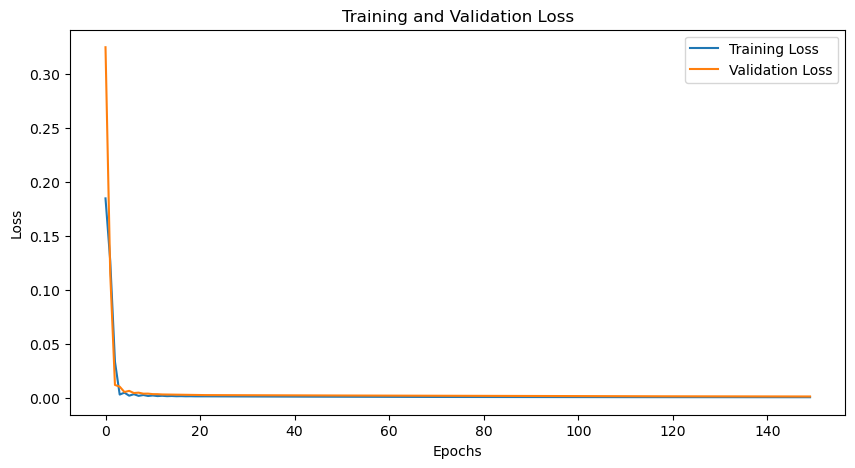

MSE: 0.0014053630052087817
RMSE: 0.03748817153728335
MAE: 0.0311109816635048
R-squared: 0.9206101310961784
MAPE: 0.03081464187389474


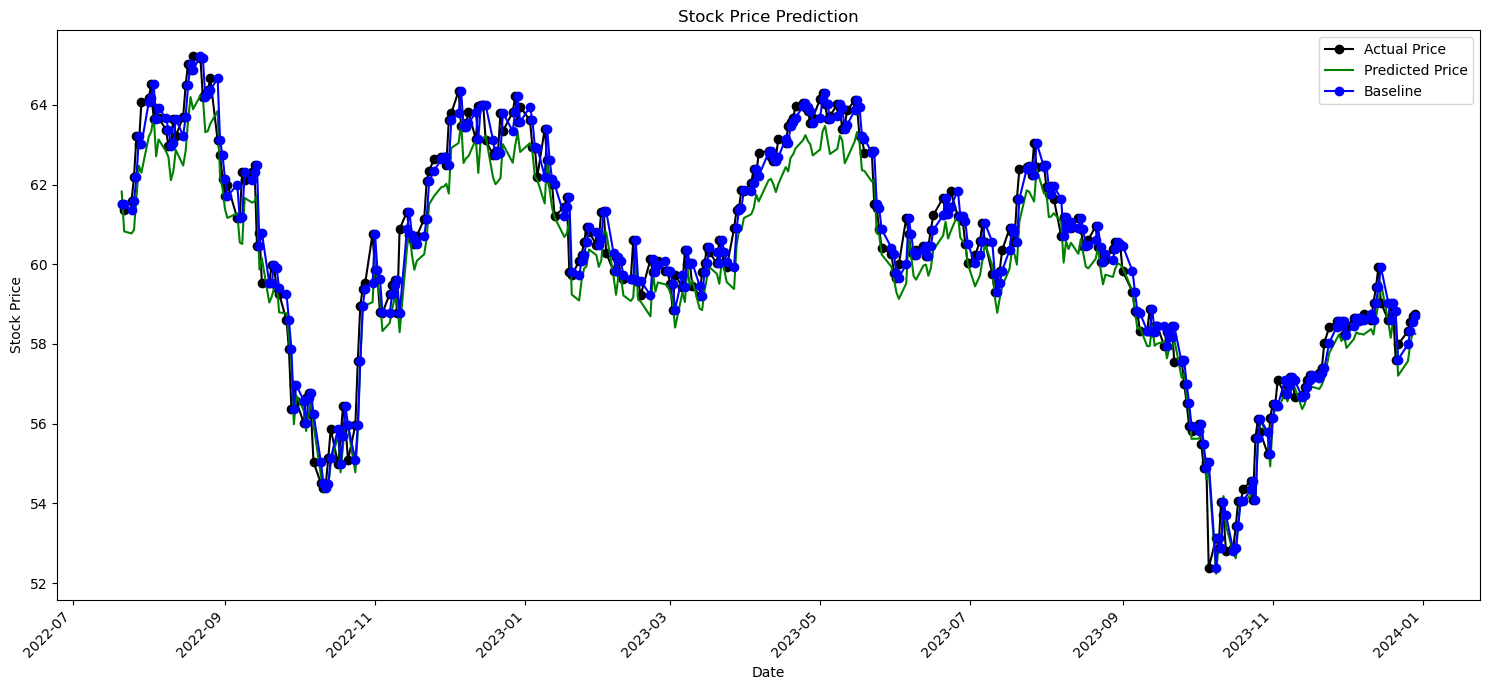

training_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,0.00078
validation_loss,0.00148


In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
from configuration import stock_ticker, company_name, architecture, num_units, num_layers, dropout_prob, model, seq_length, start_date, end_date, num_epochs, learning_rate
import wandb
import os
import tempfile
import io

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seqs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        training_loss = np.mean(train_losses)
        training_losses.append(training_loss)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for seqs, labels in val_loader:
                seqs, labels = seqs.to(device), labels.to(device)
                y_pred = model(seqs)
                val_losses.append(criterion(y_pred, labels).item())
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)

        wandb.log({"training_loss": training_loss, "validation_loss": validation_loss})

        """
        if writer:
            writer.add_scalar('Loss/train', training_loss, epoch)
            writer.add_scalar('Loss/validation', validation_loss, epoch)
        """

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Training Loss: {training_loss} | Validation Loss: {validation_loss}')
    
    return training_losses, validation_losses

def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, test_loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for seqs, labels in test_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            output = model(seqs)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())
    return np.array(predictions), np.array(actuals)

def inverse_transform_scaler(values, scaler):
    values_reshaped = values.reshape(-1, 1)
    return scaler.inverse_transform(values_reshaped)

"""
def plot_predictions_with_dates(predictions, actuals, dates, scaler):
    predictions_original_scale = inverse_transform_scaler(np.array(predictions), scaler)
    actuals_original_scale = inverse_transform_scaler(np.array(actuals), scaler)
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates, actuals_original_scale, label='Actual Price', color='blue', marker='o')
    plt.plot(dates, predictions_original_scale, label='Predicted Price', color='red', linestyle='--')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    wandb.log({"label": plt})
    plt.show()
"""

def plot_predictions_with_dates(predictions, actuals, dates, scaler):
    predictions_original_scale = list(inverse_transform_scaler(np.array(predictions), scaler))
    actuals_original_scale = list(inverse_transform_scaler(np.array(actuals), scaler))
    baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(dates, actuals_original_scale, label='Actual Price', color='black', linestyle='-', marker='o')
    ax.plot(dates, predictions_original_scale, label='Predicted Price', color='green', linestyle='-')
    ax.plot(dates, baseline_original_scale, label='Baseline', color='blue', linestyle='-', marker='o')

    ax.set_title('Stock Price Prediction')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')
    ax.legend()
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.plot()
    plt.show()
    
    filename = "plot.png"
    fig.savefig(filename)
    wandb.log({"Stock Price Prediction": wandb.Image(filename)})
    os.remove(filename)
    plt.close(fig)


wandb.init(
    project="RNN_single_step_forecasts",
    config={
        "dataset": f"{company_name} closing prices",
        "architecture": architecture,
        "num_units": num_units,
        "num_layers": num_layers,
        "dropout": dropout_prob,
        "seq_length": seq_length,
        "start_date": start_date,
        "end_date": end_date,
        "epochs": num_epochs,
        "learning_rate": learning_rate
    }
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# writer = SummaryWriter('runs/rnn_model')

# Obtaining data and preprocessing
stock_df = yf.download(stock_ticker, start=start_date, end=end_date)

split_idx = int(len(stock_df) * 0.8) + seq_length
train_df = stock_df.iloc[:split_idx]
temp_df = stock_df.iloc[split_idx:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train_df[['Close']].values.reshape(-1, 1))
X_train, y_train = create_sequences(train_normalized, seq_length)

temp_normalized = scaler.transform(temp_df[['Close']].values.reshape(-1, 1))
X_temp, y_temp = create_sequences(temp_normalized, seq_length)

split_idx_temp = len(y_temp) // 2
X_val, X_test = X_temp[:split_idx_temp], X_temp[split_idx_temp:]
y_val, y_test = y_temp[:split_idx_temp], y_temp[split_idx_temp:]

train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)

# Add model graph to tensorboard
# sample_input_tensor = torch.randn((1, seq_length, 1)).to(device)
# writer.add_graph(model, sample_input_tensor)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and validation
training_losses, validation_losses = train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
plot_losses(training_losses, validation_losses)

# Evaluation of the model on the test set
predictions, actuals = evaluate_model(model, test_loader)
dates = list(stock_df.index[(-len(predictions)):])
dates = sorted(dates)

print(f'MSE: {mean_squared_error(actuals, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(actuals, predictions))}')
print(f'MAE: {mean_absolute_error(actuals, predictions)}')
print(f'R-squared: {r2_score(actuals, predictions)}')
print(f'MAPE: {np.mean(np.abs(actuals - predictions) / actuals)}')

plot_predictions_with_dates(predictions, actuals, dates, scaler)
wandb.finish()
# writer.close()


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from configuration import stock_ticker, start_date, end_date

stock_df = yf.download(stock_ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [7]:
stock_df['baseline'] = stock_df['Close'].shift(1)
stock_df['baseline'] = stock_df['baseline'].fillna(method='bfill')
stock_df

/var/folders/72/xqxvrz7s4n7grqqwprj1mrc80000gn/T/ipykernel_3092/4173986177.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df['baseline'] = stock_df['baseline'].fillna(method='bfill')


,Open,High,Low,Close,Adj Close,Volume,baseline
Date,,,,,,,
2009-01-02,22.700001,23.000000,22.520000,22.950001,14.269992,16355800,22.950001
2009-01-05,22.785000,22.945000,22.590000,22.719999,14.126978,20237200,22.950001
2009-01-06,22.850000,22.985001,22.230000,22.355000,13.900032,21307800,22.719999
2009-01-07,22.110001,22.590000,22.110001,22.465000,13.968427,21581000,22.355000
2009-01-08,22.420000,22.639999,22.280001,22.620001,14.064803,20087000,22.465000
...,...,...,...,...,...,...,...
2023-12-22,58.119999,58.459999,58.020000,58.320000,57.857216,9028500,57.990002
2023-12-26,58.060001,58.709999,58.060001,58.560001,58.095314,6422500,58.320000
2023-12-27,58.639999,58.770000,58.400002,58.709999,58.244122,8560100,58.560001


In [8]:
wandb.init(
    project="RNN_single_step_forecasts",
    config={
        "dataset": f"{company_name} baseline",
        "architecture": architecture,
        "num_units": num_units,
        "num_layers": num_layers,
        "dropout": dropout_prob,
        "seq_length": seq_length,
        "start_date": start_date,
        "end_date": end_date,
        "epochs": num_epochs,
        "learning_rate": learning_rate
    }
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# writer = SummaryWriter('runs/rnn_model')

stock_df = yf.download(stock_ticker, start=start_date, end=end_date)

split_idx = int(len(stock_df) * 0.8) + seq_length
train_df = stock_df.iloc[:split_idx]
temp_df = stock_df.iloc[split_idx:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train_df[['baseline']].values.reshape(-1, 1))
X_train, y_train = create_sequences(train_normalized, seq_length)

temp_normalized = scaler.transform(temp_df[['baseline']].values.reshape(-1, 1))
X_temp, y_temp = create_sequences(temp_normalized, seq_length)

split_idx_temp = len(y_temp) // 2
X_val, X_test = X_temp[:split_idx_temp], X_temp[split_idx_temp:]
y_val, y_test = y_temp[:split_idx_temp], y_temp[split_idx_temp:]

train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)

# Add model graph to tensorboard
# sample_input_tensor = torch.randn((1, seq_length, 1)).to(device)
# writer.add_graph(model, sample_input_tensor)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and validation
training_losses, validation_losses = train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
plot_losses(training_losses, validation_losses)

# Evaluation of the model on the test set
predictions, actuals = evaluate_model(model, test_loader)
dates = list(stock_df.index[(-len(predictions)):])
dates = sorted(dates)

print(f'MSE: {mean_squared_error(actuals, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(actuals, predictions))}')
print(f'MAE: {mean_absolute_error(actuals, predictions)}')
print(f'R-squared: {r2_score(actuals, predictions)}')
print(f'MAPE: {np.mean(np.abs(actuals - predictions) / actuals)}')

plot_predictions_with_dates(predictions, actuals, dates, scaler)
wandb.finish()
# writer.close()

[*********************100%%**********************]  1 of 1 completed


KeyError: "None of [Index(['baseline'], dtype='object')] are in the [columns]"

wandb: Network error (ConnectionError), entering retry loop.
